# Using Python to analyze financial data and test automated strategies
Computational Finance, Université de Bordeaux, 2020

Nicolas Mauhé ([nicolas.mauhe@u-bordeaux.fr](mailto:nicolas.mauhe@u-bordeaux.fr))

## Table of Contents
1. [Introduction](#Introduction)
2. [Analyzing financial data](#Analyzing-financial-data)
3. [Computing financial indicators](#Computing-financial-indicators)
4. [Designing automated strategies](#Designing-automated-strategies)
1. [Selecting algos](#Selecting-algos)
1. [Customising strategies](#Customising-strategies)
1. [Combining several strategies](#Combining-several-strategies)
1. [Using professional data](#Using-professional-data)
1. [Putting it all into practice](#Putting-it-all-into-practice)
1. [Going further](#Going-further)

## Introduction

Bt is a simple Python package that can be used to fetch financial data, analyze them, establish algorithmic trading strategies, and backtest them. A complete description of the package can be found [here](http://pmorissette.github.io/bt/). It is an open-source package : which means you can access the code behind it on its [github repository](https://github.com/pmorissette/bt). Most of the Python packages work this way : so please get used to using other people work and to reading package documentations, because that is the way Python works. 

Each time you see a cell with some code in it, click on it and then on the "Run" button at the top of the page. You can also click on the cell and then use the shortcut Ctrl + Enter. Feel free to modify every cell and to run them again ! This course is made for you to experiment, and learn how to use Python. So feel free to test anything.

We first import the packages we need:
- bt to do backtesting
- pandas to use data
- numpy to do some math

If necessary, we can install bt using :

In [ ]:
!pip3 install bt

We import the package we will need:

In [1]:
import bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We can change the style of the graphs by using :

In [2]:
plt.style.use('ggplot')

All the styles are available [here](https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html).

Let's start by choosing which stock we want to invest in. We will focus on US equity. We can use any ticker symbol of any US Equity. A list can be found [here](http://eoddata.com/symbols.aspx). Let's choose three companies.

We can use the bt method `bt.get()` to fetch financial data from Yahoo. To know how a method work, we can always use the python method help().

In [3]:
help(bt.get)

Help on function get in module ffn.data:

get(tickers, provider=None, common_dates=True, forward_fill=False, clean_tickers=True, column_names=None, ticker_field_sep=':', mrefresh=False, existing=None, **kwargs)
    Helper function for retrieving data as a DataFrame.
    
    Args:
        * tickers (list, string, csv string): Tickers to download.
        * provider (function): Provider to use for downloading data.
            By default it will be ffn.DEFAULT_PROVIDER if not provided.
        * common_dates (bool): Keep common dates only? Drop na's.
        * forward_fill (bool): forward fill values if missing. Only works
            if common_dates is False, since common_dates will remove
            all nan's, so no filling forward necessary.
        * clean_tickers (bool): Should the tickers be 'cleaned' using
            ffn.utils.clean_tickers? Basically remove non-standard
            characters (^VIX -> vix) and standardize to lower case.
        * column_names (list): List of c

Alternatively, you can use the interrogation point.

In [4]:
bt.get?

This is a bit "raw", but it can be useful. Another solution is to check the [package documentation](http://pmorissette.github.io/bt/index.html). Here is how to use `bt.get()`:

In [5]:
equity_list = ['AAPL', 'MCD', 'MSFT', 'F', 'GE']
beginning = '2010-01-01'

<AxesSubplot:xlabel='Date'>

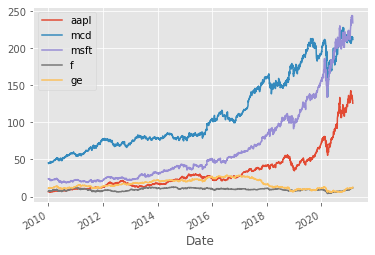

In [6]:
data = bt.get(equity_list, start=beginning)
data.plot()

An interesting argument for the drawing methods is the size you want. Just specify figsize = (length, height).

<AxesSubplot:xlabel='Date'>

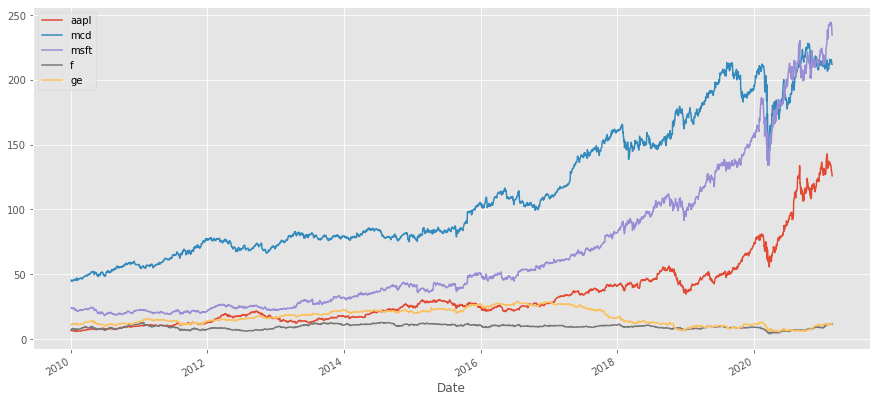

In [7]:
data.plot(figsize = (15, 7))

In [8]:
plt.rcParams["figure.figsize"] = (15, 7)

There we go ! We can now import data from any security, as long as it is available on [Yahoo Finance](https://finance.yahoo.com/).

## Analyzing financial data

We can check the type of this new Python object by using the method type()

In [9]:
type(data)

pandas.core.frame.DataFrame

It is a dataframe of the package Pandas, the most used Python package to do data analysis.

We can check the Pandas documentation about [dataframes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). Two types of "subobjects" are available for any python object : attributes (fixed objects) and methods (functions). A way to quickly get a list of these in a netbook is to type in the object name followed by a dot and to press TAB.

One can see that some interesting methods are present, such as the one used to plot the data on a graph, plot().

In [10]:
# Press TAB after "data." and choose plot()


We can also find the method hist(), used to plot an histogram of the values.

In [11]:
# Press TAB after "data." and choose hist()


Another very useful method is describe(), that gives us summary statistics about the dataset.

In [12]:
data.describe()

,aapl,mcd,msft,f,ge
count,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000
mean,33.298720,112.430119,66.601719,9.456457,16.723868
std,27.218483,50.984923,55.392190,1.690748,6.225533
min,5.908031,44.499973,18.044788,4.010000,5.467705
25%,15.502981,75.279552,24.724641,8.317253,11.653257
50%,25.204052,84.990257,42.277859,9.550058,15.438078
75%,41.885044,153.115509,92.893089,10.737509,21.758881
max,142.946396,228.283173,244.427048,12.847414,29.070246


Exercise 1 : find a way to display : 
1. The first rows of a pandas dataset. 
2. The last rows.
3. A plot the evolution of these equities during their last 30 quotes (bonus : in a single line of code)

Solution (3 commands)

In [13]:
# 1


In [14]:
# 2


In [15]:
# 3


## Computing financial indicators

Let's go further. Some useful bt methods are rebase() and to_returns().

In [16]:
data.rebase()

,aapl,mcd,msft,f,ge
Date,,,,,
2010-01-04,100.000000,100.000000,100.000000,100.000000,100.000000
2010-01-05,100.172886,99.235443,100.032326,106.614831,100.517778
2010-01-06,98.579495,97.881462,99.418413,110.603117,100.000000
2010-01-07,98.397251,98.598267,98.384462,113.424173,105.177984
2010-01-08,99.051430,98.502696,99.063027,113.715953,107.443361
...,...,...,...,...,...
2021-02-16,2023.061713,472.976701,1010.978443,165.601273,108.800347
2021-02-17,1987.366786,469.501353,1015.385923,164.740255,107.800505
2021-02-18,1970.203045,473.856521,1013.681124,164.022756,105.709943


In [17]:
data.to_returns()

,aapl,mcd,msft,f,ge
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,-0.007646,0.000323,0.066148,0.005178
2010-01-06,-0.015906,-0.013644,-0.006137,0.037408,-0.005151
2010-01-07,-0.001849,0.007323,-0.010400,0.025506,0.051780
2010-01-08,0.006648,-0.000969,0.006897,0.002572,0.021539
...,...,...,...,...,...
2021-02-16,-0.016104,0.005283,-0.005266,0.007860,0.020460
2021-02-17,-0.017644,-0.007348,0.004360,-0.005199,-0.009190
2021-02-18,-0.008636,0.009276,-0.001679,-0.004355,-0.019393


The formula of to_returns() is simply $\frac{t_1}{t_2} - 1$.

In [18]:
data_percent = (data - data.shift(1)) / data.shift(1)
data_percent

,aapl,mcd,msft,f,ge
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,-0.007646,0.000323,0.066148,0.005178
2010-01-06,-0.015906,-0.013644,-0.006137,0.037408,-0.005151
2010-01-07,-0.001849,0.007323,-0.010400,0.025506,0.051780
2010-01-08,0.006648,-0.000969,0.006897,0.002572,0.021539
...,...,...,...,...,...
2021-02-16,-0.016104,0.005283,-0.005266,0.007860,0.020460
2021-02-17,-0.017644,-0.007348,0.004360,-0.005199,-0.009190
2021-02-18,-0.008636,0.009276,-0.001679,-0.004355,-0.019393


Exercise 2 : produce the two following plots :
1. The price evolution rebased to 100 at the beginning of the plot.
2. The histogram of the returns of the three equities during last year (252 quotes).

Solution (2 commands)

In [19]:
# 1 


In [20]:
# 2


Another interesting method available for the data object is corr(). It enables us to compute the correlation matrix of our securities. Let's compute the correlation matrix of the returns.

In [21]:
data.to_returns().corr()

,aapl,mcd,msft,f,ge
aapl,1.000000,0.388113,0.556891,0.375114,0.338184
mcd,0.388113,1.000000,0.468481,0.430571,0.396489
msft,0.556891,0.468481,1.000000,0.401928,0.376475
f,0.375114,0.430571,0.401928,1.000000,0.525723
ge,0.338184,0.396489,0.376475,0.525723,1.000000


Another method, plot_corr_heatmap, enable us to get a similar result but using a heatmap.

<module 'matplotlib.pyplot' from '/home/nicolas/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

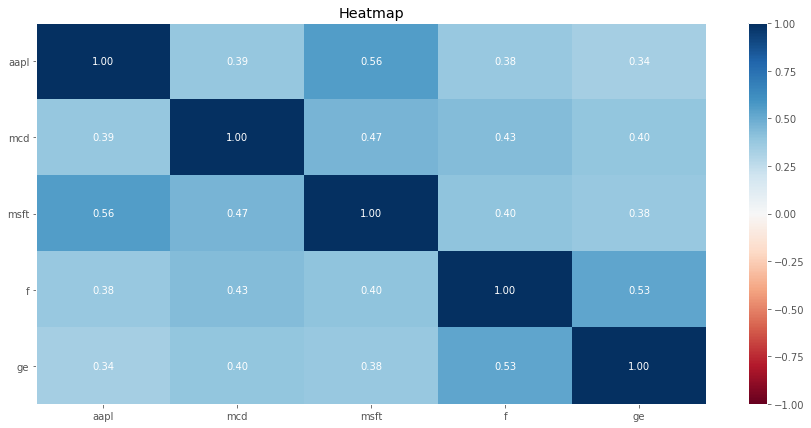

In [22]:
data.to_returns().plot_corr_heatmap()

Now, let's see how to display some more complex financial statistics about our data.

In [23]:
stats = data.calc_stats()
stats.display()

Stat                 aapl        mcd         msft        f           ge
-------------------  ----------  ----------  ----------  ----------  ----------
Start                2010-01-04  2010-01-04  2010-01-04  2010-01-04  2010-01-04
End                  2021-02-22  2021-02-22  2021-02-22  2021-02-22  2021-02-22
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         1813.85%    366.44%     875.09%     67.90%      13.62%
Daily Sharpe         1.08        0.82        0.93        0.30        0.19
Daily Sortino        1.79        1.33        1.56        0.50        0.32
CAGR                 30.35%      14.83%      22.69%      4.76%       1.15%
Max Drawdown         -43.80%     -36.90%     -28.04%     -68.79%     -81.19%
Calmar Ratio         0.69        0.40        0.81        0.07        0.01

MTD                  -4.37%      2.03%       1.33%       11.11%      17.04%
3m                   7.54%       -0.36%      11.72%      33.87%      28.19%
6m       

What does it mean ?

- Total Return: Total return on the period.
- Daily Sharpe: Daily Sharpe ratio

The Sharpe ratio : $$S(x) = \frac{R_x - r}{\sigma_x}$$
With $R_x$ being the investment return, $r$ being the riskfree rate and $\sigma_x$ being the standard deviation of the investment.
The Sharpe ratio measures the return you are receiving in comparison with the risk you are taking.

- Daily Sortino: Daily Sortino ratio

The Sortino ratio (as used in the bt package) is a variation of the Sharpe ratio, taking into account only the negative volatility. The formula is very similar :
$$S^{'}(x) = \frac{R_x - r}{\sigma^-_x}$$
With $R_x$ being the investment return, $r$ being the riskfree rate and $\sigma^-_x$ being the downside deviation of the investment.

- CAGR: Compound annual growth rate

The compound annual growth rate (CAGR) :
$${CAGR}(t_0,t_n) = (\frac{V(t_n)}{V(t_0)})^{\frac{1}{t_n-t_0}} - 1$$
It is an easy way to have an idea of the "average" return during the period : taking the actual average of the annual returns is not as good, given that volatility can affect the results.

- Max Drawdown: Maximum decline of the equity
- Calmar Ratio: Ratio of the CAGR and the absolute value of the Max Drawdown

 

 
- Daily Mean (ann.): Daily average of return, times the number of trading periods in a year (252)
- Daily Vol (ann.): Same thing with the standard deviation
- Daily Skew: Usual measure of the asymmetry, daily average
- Daily Kurt: Usual measure of "tailedness", daily average
 
 

 
  
- MTD: The month to date return
- 3m: 3 months ago to date return
- 6m: 6 months
- YTD: The beginning of the year to date return
- 1Y: One year ago to date return
- 3Y: Etc.
- 5Y: Etc.
- 10Y: Be careful : these stats are limited by the data start date !
- Since Incep. (ann.): Same thing !

To get correct statistics (such as Sharpe and Sortino ratios), we have to specify the riskfree rate on the considered period, annualized. To estimate the riskfree rate, The Treasury Bonds rate is used. The different rates available on Yahoo are [here](https://finance.yahoo.com/bonds).

In [24]:
riskfree =  bt.get('^IRX', start=beginning)
riskfree_rate = riskfree.mean() / 100
print(riskfree_rate)

irx    0.005275
dtype: float64


It is a dataframe :

In [25]:
type(riskfree_rate)

pandas.core.series.Series

Let's turn it into a float using float().

In [26]:
riskfree_rate = float(riskfree_rate)
type(riskfree_rate)

float

We can now display accurate statistics about our data.

In [27]:
stats.set_riskfree_rate(riskfree_rate)
stats.display()

Stat                 aapl        mcd         msft        f           ge
-------------------  ----------  ----------  ----------  ----------  ----------
Start                2010-01-04  2010-01-04  2010-01-04  2010-01-04  2010-01-04
End                  2021-02-22  2021-02-22  2021-02-22  2021-02-22  2021-02-22
Risk-free rate       0.53%       0.53%       0.53%       0.53%       0.53%

Total Return         1813.85%    366.44%     875.09%     67.90%      13.62%
Daily Sharpe         1.06        0.79        0.91        0.29        0.18
Daily Sortino        1.76        1.29        1.52        0.48        0.29
CAGR                 30.35%      14.83%      22.69%      4.76%       1.15%
Max Drawdown         -43.80%     -36.90%     -28.04%     -68.79%     -81.19%
Calmar Ratio         0.69        0.40        0.81        0.07        0.01

MTD                  -4.37%      2.03%       1.33%       11.11%      17.04%
3m                   7.54%       -0.36%      11.72%      33.87%      28.19%
6m       

Exercise 3:
1. Plot the price evolution of General Electric and Ford since 2013 (Tip : in a notebook you can go back in time.)
2. Display their financial indicators, with a correct riskfree rate.

Solution

In [28]:
# 1


In [29]:
# 2


## Designing automated strategies

You can establish strategies in bt in order to choose a portfolio of equities and to automatically ajust this portfolio given a determined strategy. To do so, we will use the bt.Strategy() object.

A strategy is a stack of algorithms that work one after the other, transmitting data to each other and / or stop signals. A more complete explanation can be found in the [official documentation](http://pmorissette.github.io/bt/algos.html).

A good structure for a stack of algorithm is the following one :
- frequency : which frequency should your strategy use ?
- selection: which securities should you choose ?
- weighting: how much weight should each of the selected securities have in the target portfolio?
- allocate: close out positions that are no longer needed and allocate capital to those that were selected and given target weights.

Let's take a practical example, making these choices :
- frequency : every month
- selection: all the securities available (in the dataframe)
- weighting: equal weight to all
- allocate: allocate immediately.

In [30]:
s_equal_weights = bt.Strategy('Equal weights', [bt.algos.RunMonthly(),
                                                bt.algos.SelectAll(),
                                                bt.algos.WeighEqually(),
                                                bt.algos.Rebalance()])

We then run a backtest to assess the efficiency of our automated trading strategy.

<AxesSubplot:title={'center':'Equity Progression'}>

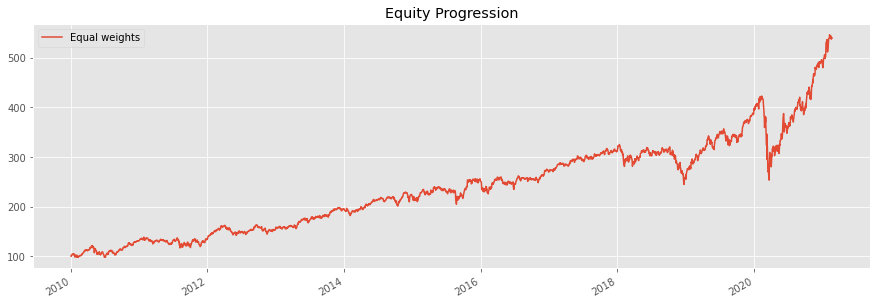

In [31]:
b_equal_weights = bt.Backtest(s_equal_weights, data)
result = bt.run(b_equal_weights)
result.plot()

We can display the same statistics we computed before, this time for the entire portfolio (and its monthly variations).

In [32]:
result.set_riskfree_rate(riskfree_rate)
result.display()

Stat                 Equal weights
-------------------  ---------------
Start                2010-01-03
End                  2021-02-22
Risk-free rate       0.53%

Total Return         440.09%
Daily Sharpe         0.83
Daily Sortino        1.31
CAGR                 16.35%
Max Drawdown         -40.08%
Calmar Ratio         0.41

MTD                  5.53%
3m                   16.49%
6m                   34.64%
YTD                  9.63%
1Y                   32.87%
3Y (ann.)            22.39%
5Y (ann.)            17.66%
10Y (ann.)           15.15%
Since Incep. (ann.)  16.35%

Daily Sharpe         0.83
Daily Sortino        1.31
Daily Mean (ann.)    17.17%
Daily Vol (ann.)     19.97%
Daily Skew           -0.27
Daily Kurt           17.09
Best Day             14.48%
Worst Day            -13.94%

Monthly Sharpe       0.96
Monthly Sortino      1.83
Monthly Mean (ann.)  16.94%
Monthly Vol (ann.)   17.04%
Monthly Skew         -0.24
Monthly Kurt         1.09
Best Month           14.56%
Worst Month

We can plot the weight variations to have an idea of the algorithm decisions regarding our portfolio.

In [33]:
b_equal_weights.security_weights.head()

,aapl,mcd,msft,f,ge
2010-01-03,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-04,0.199996,0.199992,0.200000,0.199997,0.199991
2010-01-05,0.197742,0.195888,0.197468,0.210460,0.198418
2010-01-06,0.194632,0.193250,0.196291,0.218372,0.197431
2010-01-07,0.191437,0.191825,0.191416,0.220674,0.204624


<AxesSubplot:>

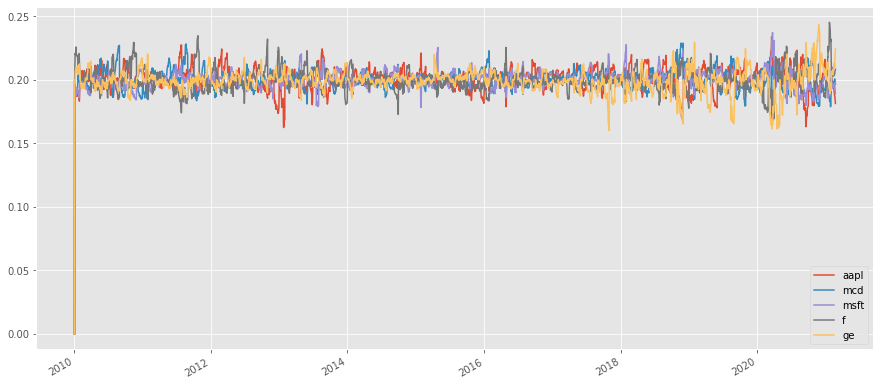

In [34]:
b_equal_weights.security_weights.plot()

Exercise 4. Let's buy the market ! We will use the Standard & Poor's 500 index.
1. Get the S&P index data from [Yahoo](https://finance.yahoo.com/).
2. Create a strategy that only buys S&P index.
3. Create a backtest on the data you fetched.
4. Run it !

Solution

<AxesSubplot:title={'center':'Equity Progression'}>

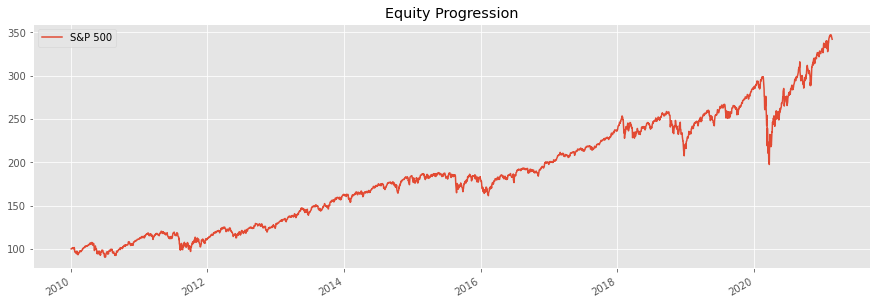

In [38]:
SNP_list = ['^GSPC'] 
beginning = '2010-01-01' 

data_SNP = bt.get("^GSPC", start=beginning)

s_sp_500 = bt.Strategy('S&P 500', [bt.algos.RunMonthly(), bt.algos.SelectAll(), bt.algos.WeighEqually(), bt.algos.Rebalance()]) 
b_sp_500 = bt.Backtest(s_sp_500, data_SNP) 
result = bt.run(b_equal_weights_SNP) 
result.plot()

## Selecting algos

### Frequency

The frequency can be just once using [RunOnce](http://pmorissette.github.io/bt/bt.html#bt.algos.RunOnce), a specific date using [RunOnDate](http://pmorissette.github.io/bt/bt.html#bt.algos.RunOnDate), or every n periods [RunEveryNPeriods](http://pmorissette.github.io/bt/bt.html#bt.algos.RunEveryNPeriods). The frequency can also be at the beginning of each day, week, month, quarter or year:
- [RunDaily](http://pmorissette.github.io/bt/bt.html#bt.algos.RunDaily)
- [RunWeekly](http://pmorissette.github.io/bt/bt.html#bt.algos.RunWeekly)
- Etc.

### Selection 

Let's see how we can select specific equities based on conditions. The algos we have are

- [SelectAll](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectAll)
- [SelectHasData](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectHasData)
- [SelectMomentum](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectMomentum)
- [SelectN](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectN)
- [SelectRandomly](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectRandomly)
- [SelectThese](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectThese)
- [SelectWhere](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectWhere)

We will use SelectRandomly to conduct a quick experiment. We will choose at random 10 securities among some of the most famous US companies, and invest in them equally.

In [39]:
equity_list = ['AAPL', 'MCD', 'MSFT', 'TGT', 'GE', 'AMZN', 'T', 'UPS', 'GM', 'IBM', 'PEP', 'VZ', 'DIS', 'INTC', 'FORD', 'CMCSA', 'IEF']
data = bt.get(equity_list, start=beginning)
data.head()

,aapl,mcd,msft,tgt,ge,amzn,t,ups,gm,ibm,pep,vz,dis,intc,ford,cmcsa,ief
Date,,,,,,,,,,,,,,,,,
2010-11-18,9.488224,58.630646,20.497398,41.428867,11.651776,164.169998,16.093496,50.071987,26.425232,102.778458,47.900017,20.438568,32.733295,15.425934,3.46,8.489524,79.560783
2010-11-19,9.435930,59.090672,20.378408,42.170269,11.782534,164.820007,16.025589,50.762447,26.479336,103.269730,47.855644,20.401003,32.236801,15.513994,3.51,8.485398,79.724854
2010-11-22,9.639886,59.001652,20.410135,41.765862,11.644513,170.389999,16.008610,50.527382,26.340223,103.511780,47.848248,20.344669,32.184544,15.594721,3.50,8.419359,80.151459
2010-11-23,9.497454,58.623234,19.926264,41.368958,11.448378,168.199997,15.861486,50.064655,25.698719,101.938377,47.249214,20.275810,31.461592,15.477301,3.57,8.316183,80.315506
2010-11-24,9.684191,58.971958,20.124575,42.874241,11.579133,177.250000,15.923729,51.115009,25.876482,103.810814,47.574623,20.250767,32.114853,15.697458,3.82,8.411108,79.454132


Exercise 5 : 
1. Let's build our random strategy. It is the same strategy as before, but this time we use SelectRandomly in our algo stack. We only select 10 securities.
2. Compare this strategy to the S & P Index (run both of them at the same time).

Solution

### Weights

Two basic weighting algorithms :

- [WeighEqually](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighEqually)
- [WeighRandomly](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighRandomly)

Algorithms to customize the weighting : 
- [WeighSpecified](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighSpecified)
- [WeighTarget](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighTarget)

Bt provides two ready-to-go strategies to weigh your portfolio.

- [WeighInvVol](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighInvVol), which weigh the assets proportionally to the inverse of their volatility. "This is a commonly used technique for risk parity portfolios. The least volatile elements receive the highest weight under this scheme."
- [WeighERC](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighERC), in which the weights are designed so each security is contributing in the amount to the portfolio overall volatility.
- [WeighMeanVar](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighMeanVar), which is an implementation of Markowitz’s mean-variance optimization.

Let's try a strategy where we keep all the securities in data and we weigh them using the inverse of their volatility. Let's compare it to the other strategies.

In [ ]:
s_inv = bt.Strategy('Inverse of Volatility', 
                       [bt.algos.RunMonthly(),
                       bt.algos.SelectHasData(),
                       bt.algos.WeighInvVol(),
                       bt.algos.Rebalance()])

b_inv = bt.Backtest(s_inv, data)
result = bt.run(b_inv, b_sp_500)
result.set_riskfree_rate(riskfree_rate)

<AxesSubplot:title={'center':'Equity Progression'}>

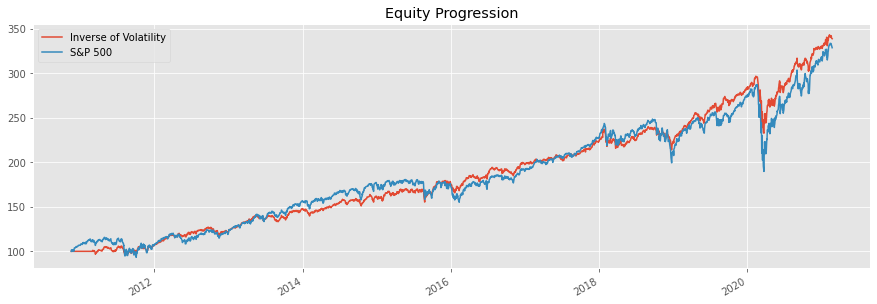

In [41]:
result.plot()

In [42]:
result.display()

Stat                 Inverse of Volatility    S&P 500
-------------------  -----------------------  ----------
Start                2010-11-17               2010-11-17
End                  2021-02-22               2021-02-22
Risk-free rate       0.53%                    0.53%

Total Return         238.87%                  228.76%
Daily Sharpe         1.03                     0.73
Daily Sortino        1.61                     1.10
CAGR                 12.62%                   12.29%
Max Drawdown         -21.58%                  -33.92%
Calmar Ratio         0.58                     0.36

MTD                  2.40%                    4.37%
3m                   5.74%                    8.96%
6m                   9.80%                    14.11%
YTD                  2.46%                    3.21%
1Y                   15.76%                   16.14%
3Y (ann.)            15.04%                   12.75%
5Y (ann.)            14.12%                   14.77%
10Y (ann.)           12.98%            

What can we conclude ?

Exercise 7 : Create a strategy that will take all the securities and weigh the securities according to Markowitz Mean-Variance portfolio theory. Compare it to the others.

Solution

## Customising strategies

### Selection

As we have seen, there are two interesting bt.algos that enable us to manually select and attribute weights :
- [SelectWhere](http://pmorissette.github.io/bt/bt.html?#bt.algos.SelectWhere)
- [WeighTarget](http://pmorissette.github.io/bt/bt.html?#bt.algos.WeighTarget)

They take as argument a DataFrame indicating True or False for SelectWhere and the weights for WeighTarget.

Let's start with SelectWhere. We need to give it a boolean DataFrame, which is composed only of True or False.

In [43]:
data.tail()

,aapl,mcd,msft,tgt,ge,amzn,t,ups,gm,ibm,pep,vz,dis,intc,ford,cmcsa,ief
Date,,,,,,,,,,,,,,,,,
2021-02-16,133.190002,215.029999,243.139999,190.589996,11.97,3268.949951,28.969999,160.732330,53.459999,120.070000,134.380005,54.150002,186.350006,62.470001,4.88,52.840000,116.940002
2021-02-17,130.839996,213.449997,244.199997,193.600006,11.86,3308.639893,29.570000,159.987045,52.889999,119.970001,134.460007,56.990002,186.440002,61.849998,4.74,52.990002,117.019997
2021-02-18,129.710007,215.429993,243.789993,191.410004,11.63,3328.229980,29.230000,161.099991,52.160000,120.730003,135.369995,56.980000,183.000000,61.610001,4.46,52.560001,117.010002
2021-02-19,129.869995,212.240005,240.970001,188.820007,12.02,3249.899902,29.000000,160.539993,52.570000,118.989998,132.509995,56.450001,183.649994,63.009998,4.59,52.099998,116.540001
2021-02-22,126.000000,212.059998,234.509995,188.990005,12.50,3180.739990,29.320000,161.600006,51.980000,120.860001,131.990005,56.450001,191.759995,60.709999,4.17,52.500000,116.349998


In [44]:
selection = data > 100
selection.tail()

,aapl,mcd,msft,tgt,ge,amzn,t,ups,gm,ibm,pep,vz,dis,intc,ford,cmcsa,ief
Date,,,,,,,,,,,,,,,,,
2021-02-16,True,True,True,True,False,True,False,True,False,True,True,False,True,False,False,False,True
2021-02-17,True,True,True,True,False,True,False,True,False,True,True,False,True,False,False,False,True
2021-02-18,True,True,True,True,False,True,False,True,False,True,True,False,True,False,False,False,True
2021-02-19,True,True,True,True,False,True,False,True,False,True,True,False,True,False,False,False,True
2021-02-22,True,True,True,True,False,True,False,True,False,True,True,False,True,False,False,False,True


Let's create a strategy based on this boolean DataFrame:

In [45]:
s_custom_selection = bt.Strategy('Custom selection', 
                       [bt.algos.RunMonthly(),
                       bt.algos.SelectWhere(selection),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

b_custom_selection = bt.Backtest(s_custom_selection, data)

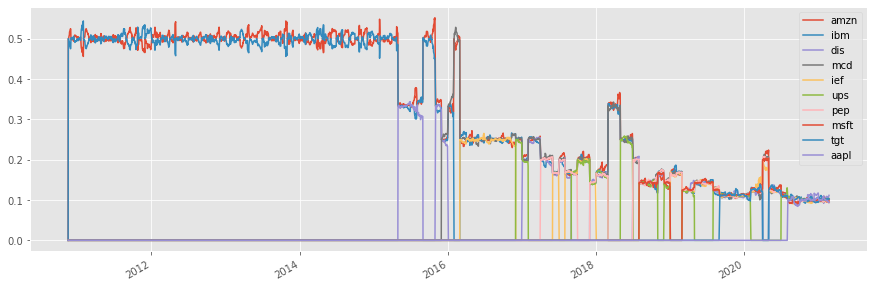

In [46]:
result = bt.run(b_custom_selection)
result.plot_security_weights()

We can use all the price methods in bt to change our data and establish interesting conditions. We can also change our data using pandas method. For instance, let's establish the following strategy : we want to invest in securities who are going up.

In [47]:
data.to_returns().head()

,aapl,mcd,msft,tgt,ge,amzn,t,ups,gm,ibm,pep,vz,dis,intc,ford,cmcsa,ief
Date,,,,,,,,,,,,,,,,,
2010-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-19,-0.005511,0.007846,-0.005805,0.017896,0.011222,0.003959,-0.004220,0.013789,0.002047,0.004780,-0.000926,-0.001838,-0.015168,0.005709,0.014451,-0.000486,0.002062
2010-11-22,0.021615,-0.001506,0.001557,-0.009590,-0.011714,0.033794,-0.001060,-0.004631,-0.005254,0.002344,-0.000155,-0.002761,-0.001621,0.005203,-0.002849,-0.007783,0.005351
2010-11-23,-0.014775,-0.006414,-0.023707,-0.009503,-0.016844,-0.012853,-0.009190,-0.009158,-0.024355,-0.015200,-0.012519,-0.003385,-0.022463,-0.007529,0.020000,-0.012255,0.002047
2010-11-24,0.019662,0.005949,0.009952,0.036387,0.011421,0.053805,0.003924,0.020980,0.006917,0.018368,0.006887,-0.001235,0.020764,0.014225,0.070028,0.011414,-0.010725


In [48]:
selection = data.to_returns() > 0
selection.head()

,aapl,mcd,msft,tgt,ge,amzn,t,ups,gm,ibm,pep,vz,dis,intc,ford,cmcsa,ief
Date,,,,,,,,,,,,,,,,,
2010-11-18,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-11-19,False,True,False,True,True,True,False,True,True,True,False,False,False,True,True,False,True
2010-11-22,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,True
2010-11-23,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True
2010-11-24,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False


<AxesSubplot:title={'center':'Equity Progression'}>

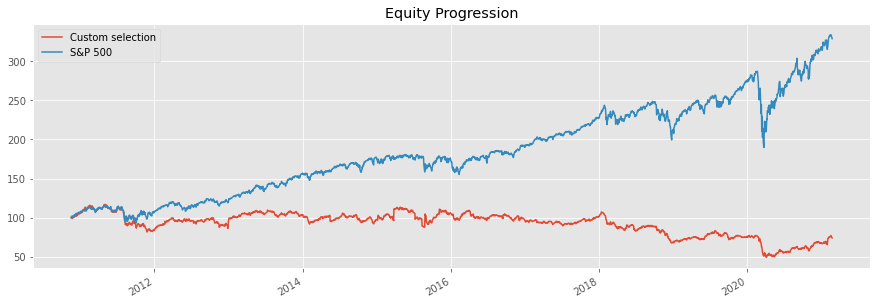

In [49]:
s_custom_selection = bt.Strategy('Custom selection', 
                       [bt.algos.RunDaily(),
                       bt.algos.SelectWhere(selection),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

b_custom_selection = bt.Backtest(s_custom_selection, data)
result = bt.run(b_custom_selection, b_sp_500)
result.plot()

It does not seem to be a good strategy.

Another possibility is to use the pandas DataFrame method [rolling](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html) to consider moving averages.

<AxesSubplot:xlabel='Date'>

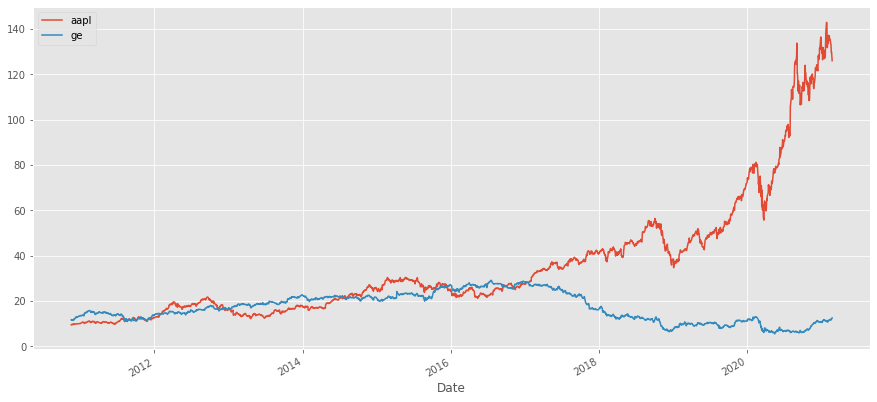

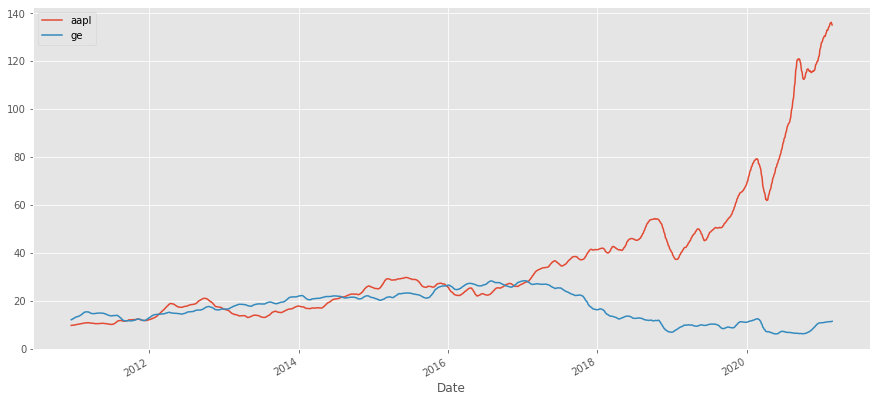

In [50]:
moving_average_data = data.rolling(20).mean()
data[['aapl', 'ge']].plot(figsize = (15, 7))
moving_average_data[['aapl', 'ge']].plot(figsize = (15, 7))

On a single plot:

<AxesSubplot:xlabel='Date'>

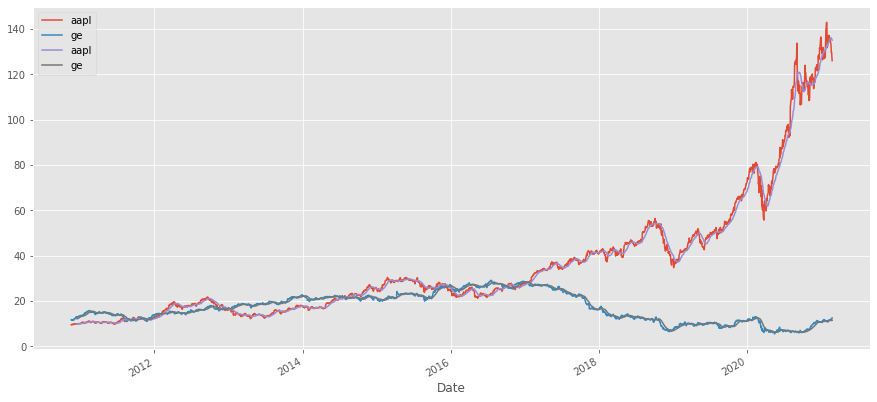

In [51]:
bt.merge(data[['aapl', 'ge']], data.rolling(20).mean()[['aapl', 'ge']]).plot(figsize = (15, 7))

In [52]:
selection = data > moving_average_data

<AxesSubplot:title={'center':'Equity Progression'}>

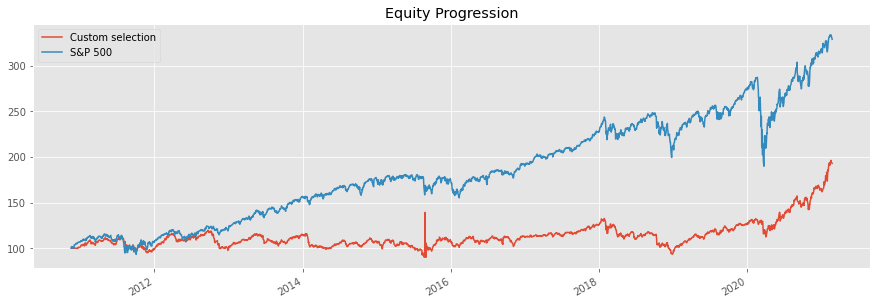

In [53]:
s_custom_selection = bt.Strategy('Custom selection', 
                       [bt.algos.RunDaily(),
                       bt.algos.SelectWhere(selection),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

b_custom_selection = bt.Backtest(s_custom_selection, data)
result = bt.run(b_custom_selection, b_sp_500)
result.plot()

Exercise: A classic strategy is to compare a moving average over a long period (50 days for instance) and another moving average over a shorter period, (let's say 15 days). If the more recent moving average is above, then some investors consider it as a signal of an uptrend. 

Apply this strategy to your data, simulate the results: is it efficient ?

Solution

Exercise 8 : You wish to evaluate the volatility of the securities before investing.
1. Compute the dataset with a daily standard deviation over the last 10 periods.
2. Compute the price mean over the last 10 periods, daily.
3. Invest only in equities whose ratio std / mean is below 5% (over the last 10 periods).

Solution

In [54]:
# 1

In [55]:
# 2

In [56]:
# 3

### Weights

Ok, we can do exactly the same with weights. All we have to do is provide a DataFrame with custom weights. It is a bit more difficult though, because we have to make sure that all the weights sum up to 1. A little trick to transform any value in proportionate weight :

In [57]:
d = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(data=d)
print(df)

   col1  col2
0     1     3
1     2     4


In [58]:
print(df.sum(axis=1))

0    4
1    6
dtype: int64


In [59]:
print(df.div(df.sum(axis=1), axis=0))

       col1      col2
0  0.250000  0.750000
1  0.333333  0.666667


Let's apply this to our DataFrame data.

In [60]:
data.head()

,aapl,mcd,msft,tgt,ge,amzn,t,ups,gm,ibm,pep,vz,dis,intc,ford,cmcsa,ief
Date,,,,,,,,,,,,,,,,,
2010-11-18,9.488224,58.630646,20.497398,41.428867,11.651776,164.169998,16.093496,50.071987,26.425232,102.778458,47.900017,20.438568,32.733295,15.425934,3.46,8.489524,79.560783
2010-11-19,9.435930,59.090672,20.378408,42.170269,11.782534,164.820007,16.025589,50.762447,26.479336,103.269730,47.855644,20.401003,32.236801,15.513994,3.51,8.485398,79.724854
2010-11-22,9.639886,59.001652,20.410135,41.765862,11.644513,170.389999,16.008610,50.527382,26.340223,103.511780,47.848248,20.344669,32.184544,15.594721,3.50,8.419359,80.151459
2010-11-23,9.497454,58.623234,19.926264,41.368958,11.448378,168.199997,15.861486,50.064655,25.698719,101.938377,47.249214,20.275810,31.461592,15.477301,3.57,8.316183,80.315506
2010-11-24,9.684191,58.971958,20.124575,42.874241,11.579133,177.250000,15.923729,51.115009,25.876482,103.810814,47.574623,20.250767,32.114853,15.697458,3.82,8.411108,79.454132


In [61]:
data.div(data.sum(axis=1), axis=0).head()

,aapl,mcd,msft,tgt,ge,amzn,t,ups,gm,ibm,pep,vz,dis,intc,ford,cmcsa,ief
Date,,,,,,,,,,,,,,,,,
2010-11-18,0.013378,0.082666,0.028900,0.058413,0.016428,0.231472,0.022691,0.070599,0.037258,0.144913,0.067537,0.028817,0.046152,0.021750,0.004878,0.011970,0.112177
2010-11-19,0.013254,0.082999,0.028624,0.059233,0.016550,0.231507,0.022510,0.071301,0.037193,0.145053,0.067218,0.028655,0.045280,0.021791,0.004930,0.011919,0.111982
2010-11-22,0.013439,0.082257,0.028455,0.058228,0.016234,0.237549,0.022318,0.070443,0.036722,0.144311,0.066708,0.028364,0.044870,0.021741,0.004880,0.011738,0.111743
2010-11-23,0.013390,0.082650,0.028093,0.058324,0.016141,0.237137,0.022362,0.070584,0.036231,0.143718,0.066615,0.028586,0.044356,0.021821,0.005033,0.011725,0.113233
2010-11-24,0.013366,0.081393,0.027776,0.059175,0.015982,0.244640,0.021978,0.070549,0.035715,0.143280,0.065662,0.027950,0.044325,0.021666,0.005272,0.011609,0.109663


We can apply this strategy to any transformation of ou dataframe. For instance, if we take the inverse of the standard deviation, we can create weights from it. Let's compute (daily) a three month (about 57 quotes) standard deviation.

In [62]:
std = data.to_returns().rolling(57).std()
std.tail()

,aapl,mcd,msft,tgt,ge,amzn,t,ups,gm,ibm,pep,vz,dis,intc,ford,cmcsa,ief
Date,,,,,,,,,,,,,,,,,
2021-02-16,0.019085,0.010968,0.013216,0.015101,0.020771,0.014687,0.012465,0.015377,0.027713,0.018545,0.009596,0.008613,0.025525,0.026633,0.096868,0.018024,0.002323
2021-02-17,0.018786,0.010863,0.013207,0.014726,0.020494,0.014759,0.012677,0.015207,0.027349,0.018210,0.009595,0.011187,0.025217,0.026690,0.097098,0.017958,0.002320
2021-02-18,0.018805,0.010804,0.013061,0.014827,0.020164,0.014756,0.012480,0.014404,0.027040,0.017585,0.009591,0.011142,0.024995,0.026642,0.097596,0.016712,0.002315
2021-02-19,0.018792,0.010975,0.013189,0.014900,0.020587,0.014858,0.012476,0.014322,0.026855,0.017685,0.009953,0.011191,0.024857,0.026735,0.097489,0.016695,0.002361
2021-02-22,0.019259,0.010961,0.013724,0.014899,0.021103,0.015129,0.012555,0.014307,0.026876,0.017812,0.009942,0.011181,0.025308,0.027306,0.098576,0.016723,0.002318


Let's take the elementwise inverse (1/element).

In [63]:
inv_std = 1 / std

We can now build a weight matrix from it.

In [64]:
inv_std_weights = inv_std.div(inv_std.sum(axis=1), axis=0)
inv_std_weights.tail()

,aapl,mcd,msft,tgt,ge,amzn,t,ups,gm,ibm,pep,vz,dis,intc,ford,cmcsa,ief
Date,,,,,,,,,,,,,,,,,
2021-02-16,0.036636,0.063751,0.052907,0.046302,0.033662,0.047608,0.056094,0.045470,0.025231,0.037703,0.072864,0.081180,0.027394,0.026253,0.007218,0.038794,0.300933
2021-02-17,0.037769,0.065316,0.053724,0.048180,0.034621,0.048075,0.055967,0.046658,0.025943,0.038963,0.073946,0.063421,0.028137,0.026584,0.007307,0.039510,0.305878
2021-02-18,0.037340,0.064991,0.053762,0.047359,0.034824,0.047586,0.056264,0.048751,0.025969,0.039931,0.073214,0.063024,0.028093,0.026356,0.007195,0.042017,0.303324
2021-02-19,0.037792,0.064709,0.053850,0.047663,0.034497,0.047799,0.056926,0.049589,0.026446,0.040157,0.071354,0.063460,0.028571,0.026564,0.007285,0.042539,0.300799
2021-02-22,0.036903,0.064841,0.051789,0.047702,0.033679,0.046978,0.056609,0.049675,0.026445,0.039901,0.071490,0.063567,0.028083,0.026028,0.007210,0.042501,0.306600


Let's weight our portfolio using this weight matrix ! And let's compare it to the bt algo that does exactly the same thing.

In [65]:
s_inv = bt.Strategy('Inverse of Volatility', 
                       [bt.algos.RunAfterDays(57),
                       bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighInvVol(),
                       bt.algos.Rebalance()])

b_inv = bt.Backtest(s_inv, data)

In [66]:
s_custom_weighting = bt.Strategy('Custom weighting', 
                       [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighTarget(inv_std_weights),
                       bt.algos.Rebalance()])

b_custom_weighting = bt.Backtest(s_custom_weighting, data)

In [ ]:
result = bt.run(b_custom_weighting, b_inv)

<AxesSubplot:title={'center':'Equity Progression'}>

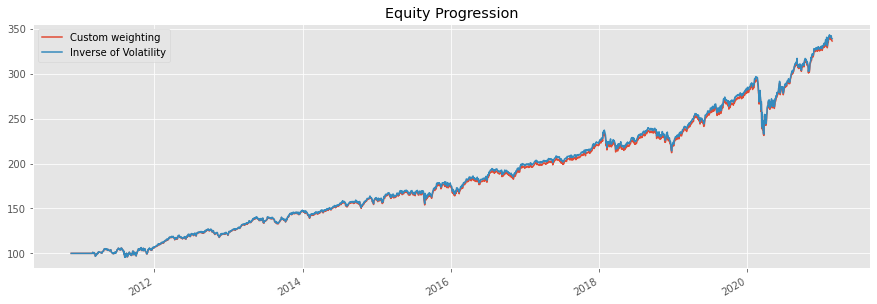

In [68]:
result.plot()

We managed to reproduce manually the WeighInv algo.

Exercise 10 : Let's try the opposite strategy ! Invest more in securities that are more volatile (proportionately to their three month standard deviation)

Solution

## Combining several strategies

We can get the price evolution of our portfolio using the attribute "prices" of the backtest result.

In [ ]:
result = bt.run(b_inv, b_sp_500)

In [71]:
result.prices.rebase().head()

,Inverse of Volatility,S&P 500
2010-11-17,100.0,100.000000
2010-11-18,100.0,101.534694
2010-11-19,100.0,101.792458
2010-11-22,100.0,101.632204
2010-11-23,100.0,100.181451


<AxesSubplot:title={'center':'Equity Progression'}>

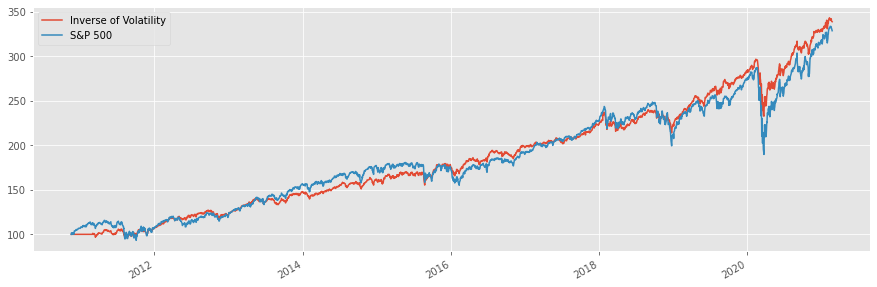

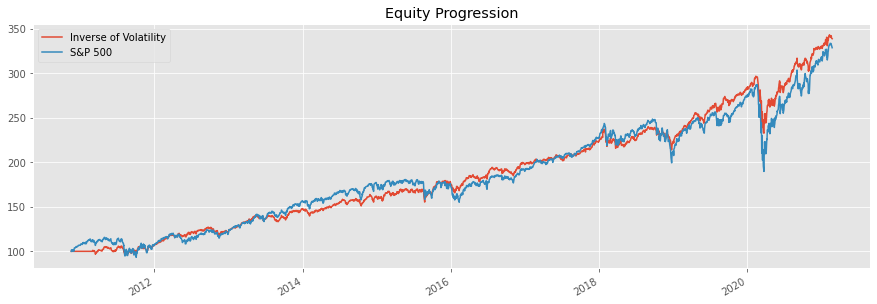

In [70]:
result.prices.rebase().plot(figsize = (15, 5))
result.plot()

If we think about it, this is the performance of our portfolio (the price we could sell the shares for). So in our backtest, we could use these portfolio instead of the company shares. And then we could do strategies based on strategies (instead of shares). Strategies of strategies !

Thus we can use it as data to backtest strategies built upon those strategies.

In [72]:
custom_weights = result.prices * 0 
custom_weights['Inverse of Volatility'] = 0.5
custom_weights['S&P 500'] = 0.5

In [73]:
custom_weights.head()

,Inverse of Volatility,S&P 500
2010-11-17,0.5,0.5
2010-11-18,0.5,0.5
2010-11-19,0.5,0.5
2010-11-22,0.5,0.5
2010-11-23,0.5,0.5


In [74]:
s_both = bt.Strategy('Half volatility, half S&P', 
                     [bt.algos.RunDaily(),
                      bt.algos.SelectAll(),
                      bt.algos.WeighTarget(custom_weights),
                      bt.algos.Rebalance()])
b_both = bt.Backtest(s_both, result.prices)

In [ ]:
result = bt.run(b_both, b_inv, b_sp_500)

<AxesSubplot:title={'center':'Equity Progression'}>

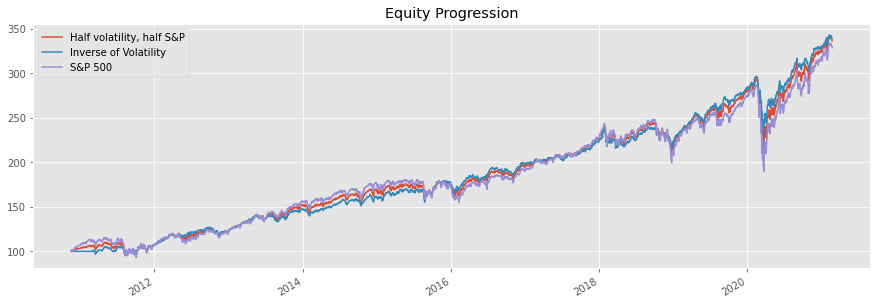

In [76]:
result.plot()

This opens a lot of possibilities ! We can have portfolios of a lot of different strategies, and we can design a strategy to select / weight these strategies depending on their performance or their volatility.

## Using professional data

We will now see how to use a more serious data provider, [Quandl](https://www.quandl.com/). Quandl has its own Python package to make fetching data easy. (If you are on your own Python notebook / IDE, please run `pip install quandl`.

In [78]:
import quandl

A full documentation on how to use quandl is available [here](https://docs.quandl.com/docs).

As all data providers, Quandl needs you to register, and will give you an API key. This is a key you put in your code (Python, R, or any other language). It is used to open the access to the data, and Quandl uses it to monitor your data consumption. A free account is limited. If you want to access top notch data (such as real time data), you will need to pay. We will use a free account.

Once you are on [Quandl](https://www.quandl.com/), click on SIGN IN on the top-right corner and create an account. Quandl will give you your API key straightaway : please copy and paste it below.

In [83]:
my_api_key = ""

Let's tell Quandl our api key.

In [84]:
quandl.ApiConfig.api_key = my_api_key

Quandl has a method similar to bt.get(). It is quandl.get():

In [85]:
help(quandl.get)

Help on function get in module quandl.get:

get(dataset, **kwargs)
    Return dataframe of requested dataset from Quandl.
    :param dataset: str or list, depending on single dataset usage or multiset usage
            Dataset codes are available on the Quandl website
    :param str api_key: Downloads are limited to 50 unless api_key is specified
    :param str start_date, end_date: Optional datefilers, otherwise entire
           dataset is returned
    :param str collapse: Options are daily, weekly, monthly, quarterly, annual
    :param str transform: options are diff, rdiff, cumul, and normalize
    :param int rows: Number of rows which will be returned
    :param str order: options are asc, desc. Default: `asc`
    :param str returns: specify what format you wish your dataset returned as,
        either `numpy` for a numpy ndarray or `pandas`. Default: `pandas`
    :returns: :class:`pandas.DataFrame` or :class:`numpy.ndarray`
    Note that Pandas expects timeseries data to be sorte

A more complete documentation can be found [here](https://docs.quandl.com/docs/parameters-2#section-times-series-parameters). It is pretty straightforward. We use it almost the same way we use bt.get(), except quandl has a lot a databases, so we have to specify the database before the ticker symbol. [A lot of databases are free](https://www.quandl.com/search?filters=%5B%22Equities%22%2C%22Free%22%5D) on Quandl, in particular [Euronext](https://www.quandl.com/data/EURONEXT-Euronext-Stock-Exchange).

In [86]:
data = quandl.get('EURONEXT/AF', start_date = '2018-05-01', end_date = '2018-07-01')

In [87]:
data.head()

,Open,High,Low,Last,Volume,Turnover
Date,,,,,,
2018-05-02,8.206,8.716,8.204,8.656,9624575.0,8.254000e+07
2018-05-03,8.700,8.714,8.226,8.334,7843289.0,6.565041e+07
2018-05-04,7.990,8.322,7.626,8.096,17752809.0,1.408469e+08
2018-05-07,7.110,7.332,6.932,7.300,22427228.0,1.601095e+08
2018-05-08,7.300,7.582,7.202,7.248,10016151.0,7.335217e+07


We could select the right column in the pandas DataFrame:

In [88]:
data[['Last']].head()

,Last
Date,
2018-05-02,8.656
2018-05-03,8.334
2018-05-04,8.096
2018-05-07,7.300
2018-05-08,7.248


But this leaves a big data object in our memory, and we will not be using most of it. In the [documentation](https://docs.quandl.com/docs/parameters-2#section-times-series-parameters), we can see that the `column_index` option can be used to select the columns. Here we are only interested in the fourth column.

In [89]:
data = quandl.get('EURONEXT/AF', start_date = '2016-01-01', column_index = 4)
data.head()

,Last
Date,
2016-01-04,7.250
2016-01-05,7.490
2016-01-06,7.550
2016-01-07,7.581
2016-01-08,7.676


Let's try with our list of equities, `equity_list`.

If we want to fetch a list of equities:

In [90]:
euronext_equity_list = ['EURONEXT/AF', 'EURONEXT/CDI', 'EURONEXT/CNP']

In [91]:
data = quandl.get(euronext_equity_list, start_date = '2016-01-01', column_index = 4)
data.head()

,EURONEXT/AF - Last,EURONEXT/CDI - Last,EURONEXT/CNP - Last
Date,,,
2016-01-04,7.250,153.15,11.875
2016-01-05,7.490,151.30,12.010
2016-01-06,7.550,147.65,11.795
2016-01-07,7.581,146.25,11.480
2016-01-08,7.676,145.60,10.975


In [92]:
equity_list = ['AF', 'CDI', 'CNP']
euronext_equity_list = ['EURONEXT/' + ticker for ticker in equity_list]
euronext_equity_list

['EURONEXT/AF', 'EURONEXT/CDI', 'EURONEXT/CNP']

To make things pretty:

In [93]:
data.columns = equity_list
data.head()

,AF,CDI,CNP
Date,,,
2016-01-04,7.250,153.15,11.875
2016-01-05,7.490,151.30,12.010
2016-01-06,7.550,147.65,11.795
2016-01-07,7.581,146.25,11.480
2016-01-08,7.676,145.60,10.975


Perfect. If we want to fetch a big number of ticker symbols, it is more convenient to read the list of ticker symbol from a csv file. Here is how to do it.

In [94]:
big_list = []
import csv
with open('Euronext_Equities.csv', 'r', errors='ignore') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    for row in spamreader:
        big_list.append(row[2])

equity_list = big_list[1:]
equity_list[:20]

['AALB',
 'ABI',
 'ABN',
 'AC',
 'ACKB',
 'ADE',
 'ADP',
 'ADYEN',
 'AED',
 'AGN',
 'AFG',
 'AGS',
 'AD',
 'A5G',
 'AF',
 'AI',
 'AIR',
 'AKER',
 'AKA',
 'AKZA']

Let's add "EURONEXT/" in front of each symbol :

In [95]:
euronext_equity_list = ['EURONEXT/' + ticker for ticker in equity_list]

In [96]:
data = quandl.get(euronext_equity_list[:50], start_date = '2016-05-01', column_index = 4)

In [97]:
data.columns = equity_list[:50]
data.head()

,AALB,ABI,ABN,AC,ACKB,ADE,ADP,ADYEN,AED,AGN,...,ATRS,AUSS,CS,BCP,BAIN,BAKKA,DD7E,DD7D,BIRG,BAR
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-02,30.010,109.10,18.895,38.975,114.65,NaN,109.90,NaN,61.19,5.085,...,3.70,NaN,22.320,0.0392,32.00,NaN,NaN,NaN,NaN,60.39
2016-05-03,29.845,108.15,18.565,38.335,114.05,NaN,109.40,NaN,60.48,4.880,...,3.67,NaN,22.050,0.0371,32.00,NaN,NaN,NaN,NaN,60.05
2016-05-04,30.060,106.45,18.750,38.340,113.90,NaN,107.00,NaN,60.15,4.856,...,3.66,NaN,21.905,0.0370,32.01,NaN,NaN,NaN,NaN,60.50
2016-05-05,30.205,109.05,18.505,38.250,114.15,NaN,107.45,NaN,60.85,4.822,...,NaN,NaN,21.645,0.0354,32.00,NaN,NaN,NaN,NaN,60.66
2016-05-06,30.180,109.25,18.130,37.820,113.10,NaN,106.75,NaN,60.85,4.835,...,3.65,NaN,20.430,0.0345,32.00,NaN,NaN,NaN,NaN,60.64


Let's clean the missing data.

In [98]:
data.dropna(axis=1, how='all', inplace=True)
data.dropna(axis=0, how='all', inplace=True)

## Putting it all into practice

Choose any data you want, using Yahoo or Quandl (or any provider you want).

Imagine we are the first of January, 2017.

Choose a strategy. Run a backtest on it. Choose the length of the backtest according to your strategey : one month, one year, 5 years...

Then test the strategy from the 1st of January 2017 to the 1st of January, 2018. Did you beat the market ? Why ? What would you change ?

(Please do not cheat and run a lot of strategies until you find one that has good returns. The mark will not depend on the return you achieved !).

## Going further

Now you know how to:
- Use Python;
- Read, run and write IPython Notebooks (= Jupyter Notebooks)
- Import a new package, use `help()` and the documentation to learn everything about the package;
- Use bt and pandas' DataFrames;
- Automatically fetch financial data from a professional source using your own API key;
- Compute basic stats and financial indicators about any equity over any period, and draw nice plots to go with it;
- Design simple and complex automated trading strategies;
- Test them over any period to assess their efficiency.

What you can do to go further:
- Keep on using Python to do things, learn more about it;
- Learn more about Pandas and data structures in Python;
- Learn more about bt to make your strategies a bit more realistic; for instance, you can set up commissions fees that will impact your portfolio returns. You can also use methods surch as [LimitDeltas](http://pmorissette.github.io/bt/bt.html#bt.algos.LimitDeltas) and [LimitWeights](http://pmorissette.github.io/bt/bt.html#bt.algos.LimitWeights) to avoid big changes in your portfolio.
- Discover other BackTesting and trading tools in Python: bt is great to start but more complete tools exist. See [here](https://www.quantstart.com/articles/backtesting-systematic-trading-strategies-in-python-considerations-and-open-source-frameworks) for a review of the possibilities.
- Use everything that your learned to experiment and test what you see in financial courses, in the news or elsewhere: using Python, Pandas and a backtesting tool such as bt, you can write strategies to test most of the theoretical things you can come across. You can use this online notebook to run things, it will remain here for a while.
- Discover the world of algorithmic trading, with different views (technical trading, fundamentalist trading, high frequency arbitrage...). You can have a glance at it thanks to online communities such as [Quantopian](https://www.quantopian.com/posts).
- Need anything ? You can email me at [nicolas.mauhe@u-bordeaux.fr](mailto:nicolas.mauhe@u-bordeaux.fr)